In [1]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
dictionary_df = pd.read_csv('train_data_dictionary.csv')

# Show the shapes and first few rows
train_shape = train_df.shape
test_shape = test_df.shape
dictionary_preview = dictionary_df.head()
train_preview = train_df.head()
test_preview = test_df.head()

(train_shape, test_shape, dictionary_preview, train_preview, test_preview)


((318438, 18),
 (137057, 17),
                  Column                           Description
 0               case_id        Case_ID registered in Hospital
 1         Hospital_code          Unique code for the Hospital
 2    Hospital_type_code  Unique code for the type of Hospital
 3    City_Code_Hospital             City Code of the Hospital
 4  Hospital_region_code           Region Code of the Hospital,
    case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
 0        1              8                  c                   3   
 1        2              2                  c                   5   
 2        3             10                  e                   1   
 3        4             26                  b                   2   
 4        5             26                  b                   2   
 
   Hospital_region_code  Available Extra Rooms in Hospital    Department  \
 0                    Z                                  3  radiotherapy   
 1                    Z

In [24]:
train_df.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [3]:
# Impute missing values with the mode (most frequent value)
train_df['Bed Grade'].fillna(train_df['Bed Grade'].mode()[0], inplace=True)
train_df['City_Code_Patient'].fillna(train_df['City_Code_Patient'].mode()[0], inplace=True)

# Verify that there are no more missing values
train_df.isnull().sum().sum()


0

In [4]:
# Identify object (categorical) columns
categorical_columns = train_df.select_dtypes(include='object').columns.tolist()

# Show number of unique values for each categorical feature
unique_counts = {col: train_df[col].nunique() for col in categorical_columns}

# Display as a DataFrame
cat_features_summary = pd.DataFrame(list(unique_counts.items()), columns=["Feature", "Unique Values"])
cat_features_summary.sort_values(by="Unique Values", ascending=False)


,Feature,Unique Values
8,Stay,11
7,Age,10
0,Hospital_type_code,7
3,Ward_Type,6
4,Ward_Facility_Code,6
2,Department,5
1,Hospital_region_code,3
5,Type of Admission,3
6,Severity of Illness,3


In [5]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode the target variable 'Stay'
label_encoder = LabelEncoder()
train_df['Stay_encoded'] = label_encoder.fit_transform(train_df['Stay'])

# Save label mappings for reference
stay_label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Step 2: One-Hot Encode other categorical features (excluding 'Stay')
categorical_features_to_encode = [
    'Age', 'Hospital_type_code', 'Hospital_region_code', 'Department',
    'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness'
]

# One-Hot Encoding
train_encoded = pd.get_dummies(train_df, columns=categorical_features_to_encode, drop_first=True)

# Show the shape before and after encoding
original_shape = train_df.shape
encoded_shape = train_encoded.shape

(original_shape, encoded_shape, stay_label_mapping)


((318438, 19),
 (318438, 46),
 {'0-10': 0,
  '11-20': 1,
  '21-30': 2,
  '31-40': 3,
  '41-50': 4,
  '51-60': 5,
  '61-70': 6,
  '71-80': 7,
  '81-90': 8,
  '91-100': 9,
  'More than 100 Days': 10})

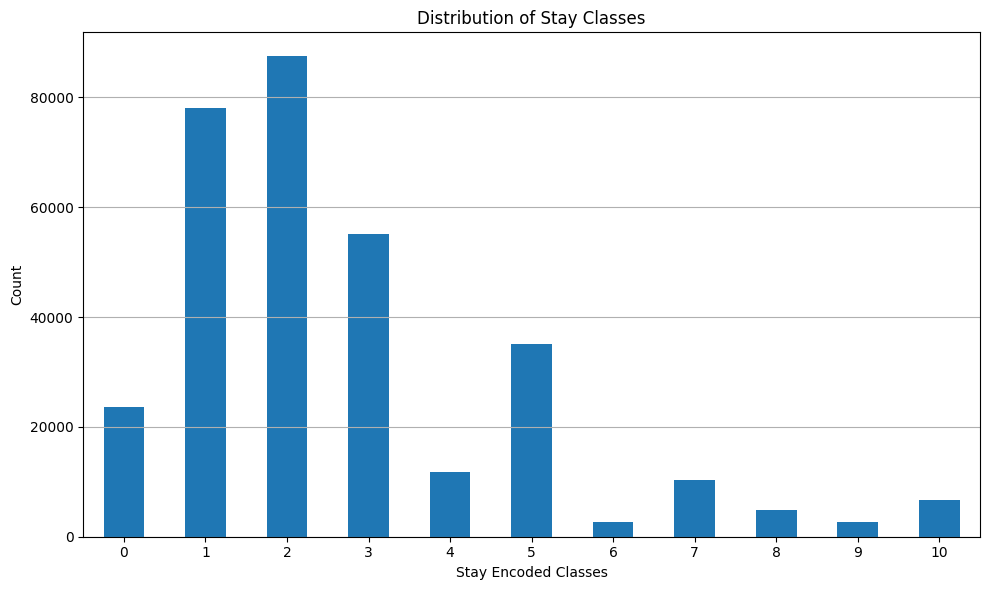

Stay_encoded
0     23604
1     78139
2     87491
3     55159
4     11743
5     35018
6      2744
7     10254
8      4838
9      2765
10     6683
Name: count, dtype: int64

In [6]:
import matplotlib.pyplot as plt

# Class distribution of the target variable
class_counts = train_df['Stay_encoded'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Distribution of Stay Classes")
plt.xlabel("Stay Encoded Classes")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

class_counts


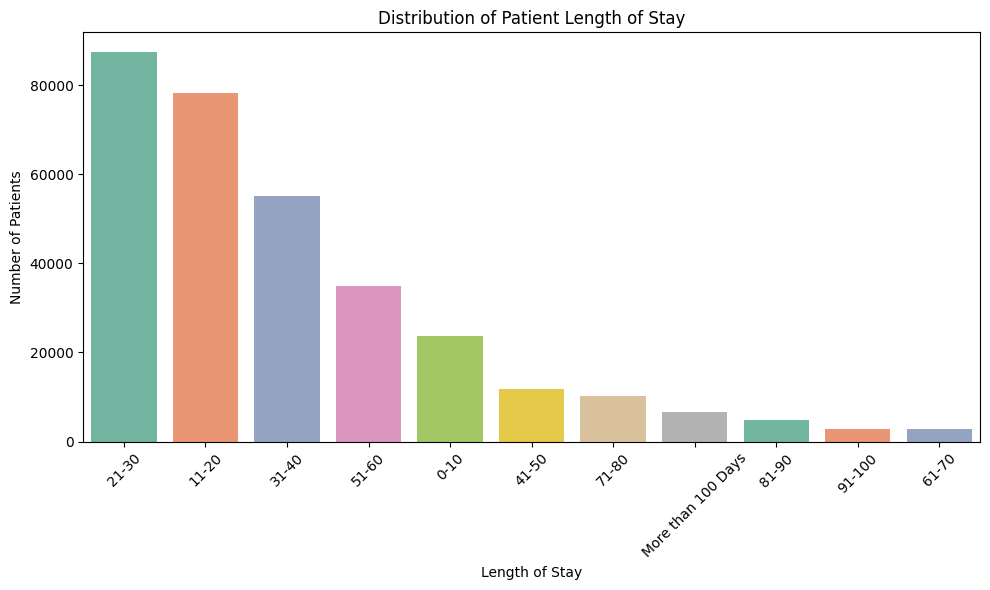

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='Stay', order=train_df['Stay'].value_counts().index, palette='Set2')
plt.title("Distribution of Patient Length of Stay")
plt.xlabel("Length of Stay")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


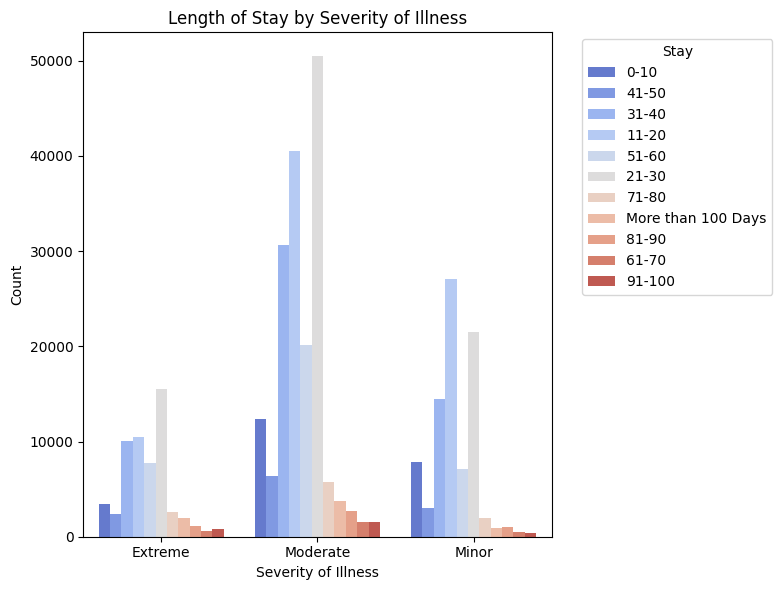

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_df, x='Severity of Illness', hue='Stay', palette='coolwarm')
plt.title("Length of Stay by Severity of Illness")
plt.xlabel("Severity of Illness")
plt.ylabel("Count")
plt.legend(title="Stay", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


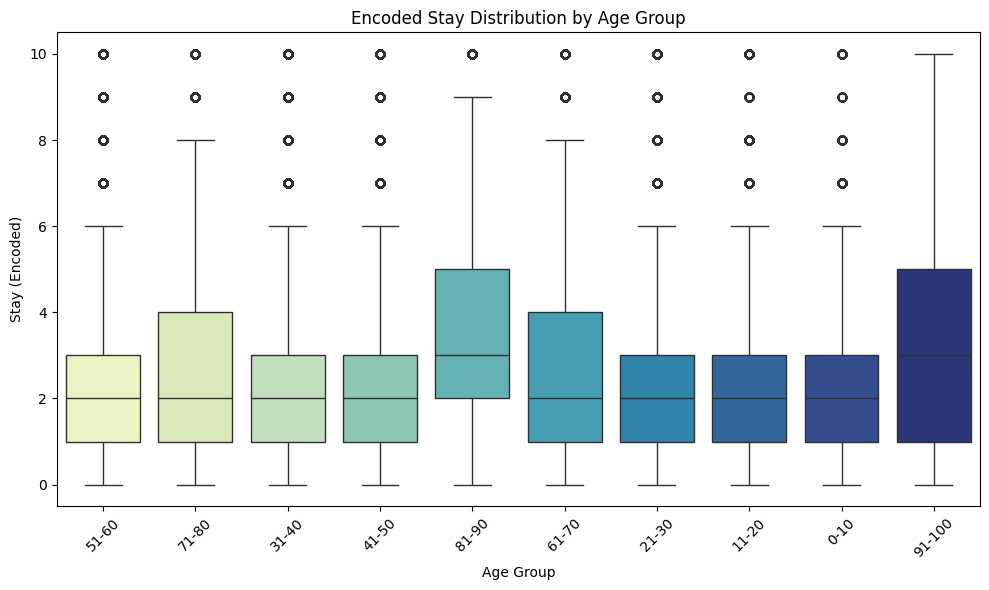

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='Age', y='Stay_encoded', palette='YlGnBu')
plt.title("Encoded Stay Distribution by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Stay (Encoded)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Drop unnecessary columns for modeling
X = train_encoded.drop(columns=['Stay', 'Stay_encoded', 'case_id', 'patientid'])
y = train_encoded['Stay_encoded']

# Train-Test Split before SMOTE (important to prevent data leakage)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Class distribution after SMOTE
resampled_class_counts = pd.Series(y_train_resampled).value_counts().sort_index()
resampled_class_counts


Stay_encoded
0     69993
1     69993
2     69993
3     69993
4     69993
5     69993
6     69993
7     69993
8     69993
9     69993
10    69993
Name: count, dtype: int64

🔍 Classification Report: Random Forest
              precision    recall  f1-score   support

           0       0.26      0.18      0.21      4721
           1       0.38      0.42      0.40     15628
           2       0.41      0.51      0.46     17498
           3       0.32      0.26      0.29     11032
           4       0.08      0.03      0.04      2349
           5       0.39      0.45      0.42      7004
           6       0.07      0.02      0.03       549
           7       0.25      0.12      0.16      2051
           8       0.37      0.26      0.31       967
           9       0.27      0.08      0.13       553
          10       0.49      0.50      0.50      1336

    accuracy                           0.37     63688
   macro avg       0.30      0.26      0.27     63688
weighted avg       0.36      0.37      0.36     63688



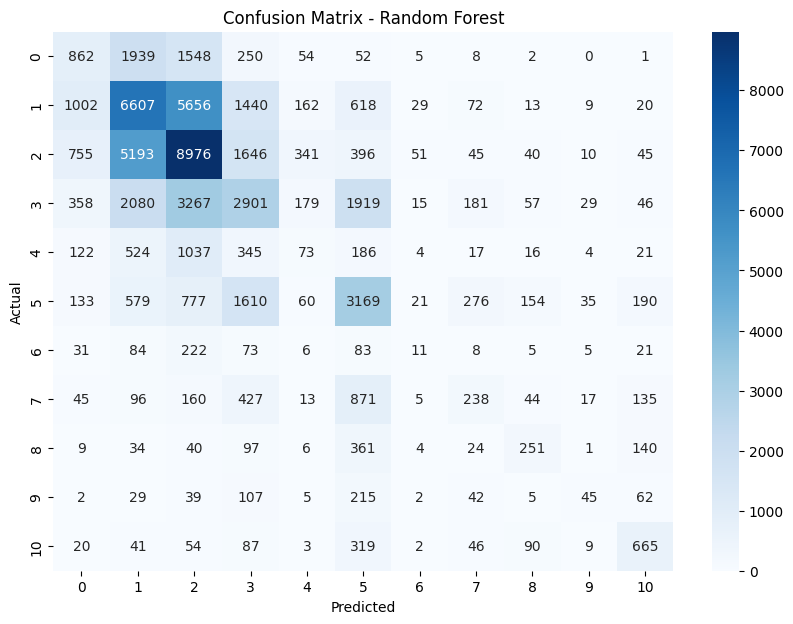

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on validation data
y_pred_rf = rf_model.predict(X_val)

# Evaluation Metrics
print("Classification Report: Random Forest")
print(classification_report(y_val, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_val, y_pred_rf)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Classification Report: XGBoost
              precision    recall  f1-score   support

           0       0.35      0.17      0.23      4721
           1       0.43      0.49      0.46     15628
           2       0.42      0.67      0.52     17498
           3       0.42      0.21      0.28     11032
           4       0.10      0.00      0.01      2349
           5       0.40      0.46      0.43      7004
           6       0.02      0.00      0.00       549
           7       0.23      0.04      0.08      2051
           8       0.30      0.29      0.29       967
           9       0.13      0.03      0.04       553
          10       0.47      0.45      0.46      1336

    accuracy                           0.42     63688
   macro avg       0.30      0.26      0.25     63688
weighted avg       0.39      0.42      0.38     63688



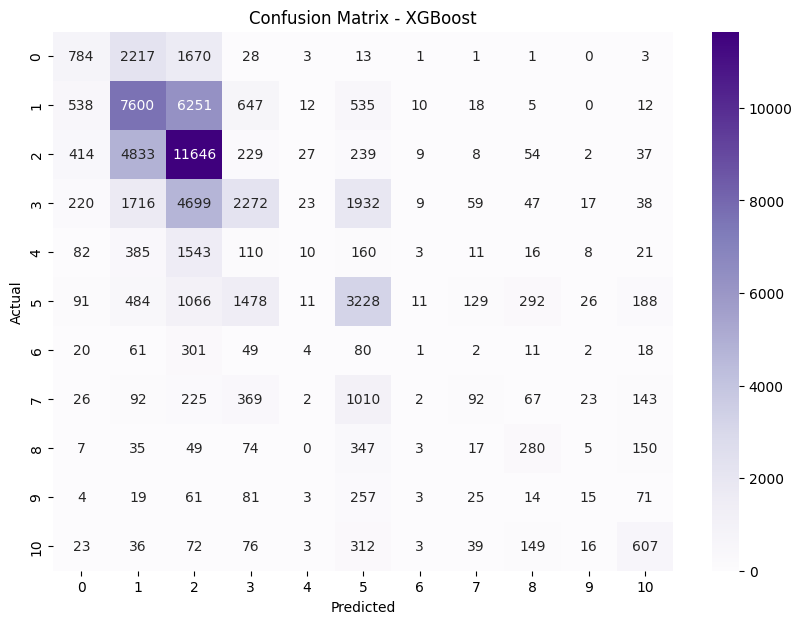

In [10]:
from xgboost import XGBClassifier

# Initialize and train the model
xgb_model = XGBClassifier(
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on validation data
y_pred_xgb = xgb_model.predict(X_val)

# Evaluation Metrics
print("Classification Report: XGBoost")
print(classification_report(y_val, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_val, y_pred_xgb)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [12]:
from sklearn.utils import resample

# Downsample to, say, 30,000 samples per class
combined = pd.concat([X_train_resampled, y_train_resampled], axis=1)
downsampled = resample(combined, replace=False, n_samples=300000, random_state=42)

X_downsampled = downsampled.drop(columns='Stay_encoded')
y_downsampled = downsampled['Stay_encoded']


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 55000, number of used features: 41
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start trai

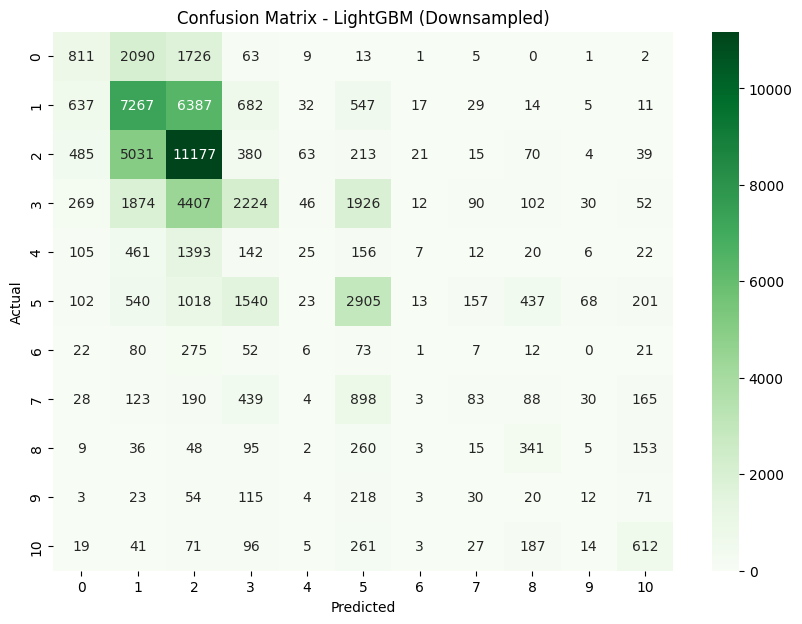

In [14]:

from sklearn.utils import shuffle

# Re-combine X and y into a single DataFrame (assumes column names still match)
X_train_resampled['Stay_encoded'] = y_train_resampled
downsampled_df = X_train_resampled.groupby('Stay_encoded').apply(
    lambda x: x.sample(n=5000, random_state=42)  # limit to 5k per class
).reset_index(drop=True)

# Separate features and target again
X_lgbm = downsampled_df.drop(columns='Stay_encoded')
y_lgbm = downsampled_df['Stay_encoded']

# Fit LightGBM on downsampled data
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_lgbm, y_lgbm)

# Predict on validation data
y_pred_lgbm = lgbm_model.predict(X_val)

# Evaluate
print("🔍 Classification Report: LightGBM")
print(classification_report(y_val, y_pred_lgbm))

# Confusion Matrix
cm_lgbm = confusion_matrix(y_val, y_pred_lgbm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - LightGBM (Downsampled)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🔍 Classification Report: Neural Network (Downsampled)
              precision    recall  f1-score   support

           0       0.34      0.01      0.02      4721
           1       0.35      0.34      0.34     15628
           2       0.38      0.71      0.50     17498
           3       0.29      0.12      0.17     11032
           4       0.06      0.00      0.00      2349
           5       0.35      0.49      0.41      7004
           6       0.00      0.00      0.00       549
           7       0.33      0.00      0.00      2051
           8       0.19      0.01      0.03       967
           9       0.03      0.00      0.01       553
          10       0.47      0.42      0.44      1336

    accuracy                           0.36     63688
   macro avg       0.26      0.19      0.17     63688
weighted avg       0.33      0.36      0.31     63688



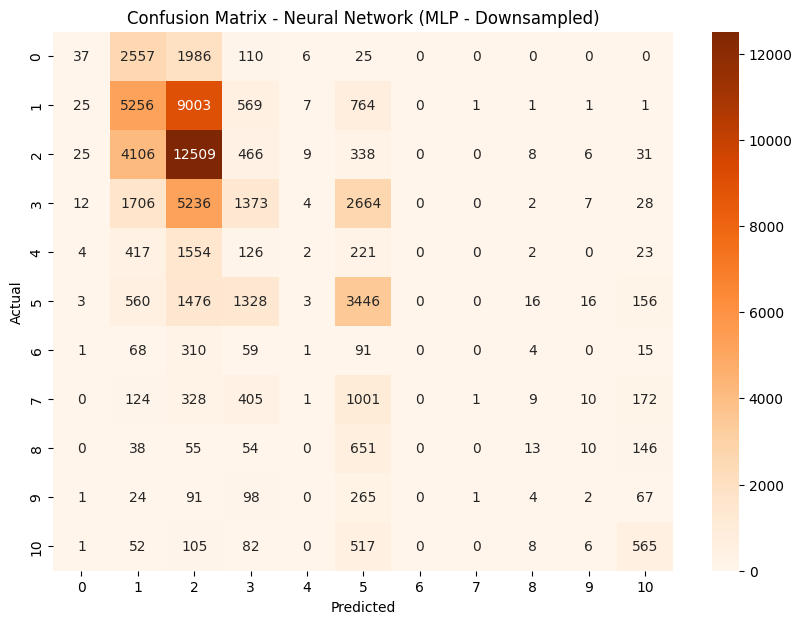

In [17]:
from sklearn.neural_network import MLPClassifier

# Reuse X_lgbm and y_lgbm from LightGBM step
from sklearn.neural_network import MLPClassifier

# Train MLP on downsampled data
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
mlp_model.fit(X_lgbm, y_lgbm)

# Predict on validation set
y_pred_mlp = mlp_model.predict(X_val)

# Evaluate
print("🔍 Classification Report: Neural Network (Downsampled)")
print(classification_report(y_val, y_pred_mlp))

# Confusion Matrix
cm_mlp = confusion_matrix(y_val, y_pred_mlp)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Neural Network (MLP - Downsampled)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
